In [1]:
import numpy as np
import pandas as pd
import math
import scipy
from scipy.stats import multivariate_normal as mvn
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

### Load Data

In [2]:
## load data
LD = pd.read_csv('data/LD.csv.gz')
LD = LD.rename(columns={'Unnamed: 0': 'SNP'})
LD = LD.set_index('SNP')
ld_matrix = LD.to_numpy()

zscore = pd.read_csv('data/zscore.csv.gz')
zscore = zscore.rename(columns={'Unnamed: 0': 'SNP'})
zscore = zscore.set_index('SNP')
z_scores = zscore.V1.tolist()

## SNP numbers
M = ld_matrix.shape[0]
## Maximum Causal SNP number
max_causal = 3

### Define Model

In [3]:
## define finmapping class
class FINEMAP :
    def __init__(self, num_SNP, max_causal):
        self.m = num_SNP
        self.max_causal = max_causal
    
    def bayes_factor(self, ld_matrix, z_scores, config_SNP):
        '''
        calculate Bayes Factor
        
        Input: ld score matrix, z score list, configuration 
        
        output: bayes factor for given configuration
        '''
        k = len(config_SNP) ##causal SNP number
        R_CC = ld_matrix[config_SNP, :][:, config_SNP]
        sigma_CC = 2.49 * np.eye(k)
        z_C = np.array([z_scores[i] for i in config_SNP])
        BF = mvn.pdf(z_C, mean=np.zeros(k), cov=R_CC + R_CC @ sigma_CC @ R_CC, allow_singular=True)/mvn.pdf(z_C, mean=np.zeros(k), cov=R_CC, allow_singular=True)
        return BF

    def prior(self, config_SNP):
        '''
        calculate Prior
        
        Input: configuration 
        
        output: prior for given configuration
        '''
        k = len(config_SNP)
        return ((1/self.m)**k)*(((self.m-1)/self.m)**(self.m-k))

    def combinations(self, m, k):
        '''
        Generate all possible Configurations
        
        Input: SNP number and max causal SNP number 
        
        output: all possible configuration
        '''
        samples = list(range(m)) ##get SNP index
        com = []
        for i in range(1,k+1):
            combinations = np.array([list(c) for c in itertools.combinations(samples, i)])
            com.extend(combinations)
        return com

    def posterior(self, ld_matrix, z_scores):
        '''
        calculate Posterior
        
        Input: ld score matrix, z scores list
        
        output: all configuration and their posterior
        '''
        m = self.m
        k = self.max_causal
        ##generate all possible configuration
        config_SNP_set= self.combinations(m, k)
        BF_set = []
        with tqdm(total = len(config_SNP_set)) as pbar:
            for config_SNP in config_SNP_set:
                config_SNP = config_SNP.astype(int)
                ##calculate BF for configuration
                BF_config = self.bayes_factor(ld_matrix, z_scores, config_SNP)
                if math.isinf(BF_config):
                    BF_config = 0
                ##calculate BF for configuration
                prior_config = self.prior(config_SNP)
                BF_set.append(BF_config * prior_config)
                pbar.update(1)
        ##calculate denominator        
        denom = sum(BF_set)
        ##calculate posterior for each configurations
        posterior = [ (bf/denom) for bf in BF_set]
        return config_SNP_set, posterior

    def pip(self, config_SNP_set, posterior):
        '''
        calculate PIP
        
        Input: configuration set, posterior set
        
        output: PIP for all configurations
        '''
        pip = []
        ##calculate denominator    
        denome = sum(posterior)
        with tqdm(total = self.m) as pbar:
            for i in range (self.m):
                nome = []
                for idx, j in enumerate(configuration):
                    if i in j:
                        ### calculate numerator
                        nome.append(posterior[idx])
                ## calculate PIP
                pip.append(sum(nome)/denome)
                pbar.update(1)
        return pip

### Implementation

In [4]:
finemap = FINEMAP(M, 3)
configuration, posterior = finemap.posterior(ld_matrix, z_scores)
pip = finemap.pip(configuration, posterior)

100%|███████████████████████████████████████████████████████████████████████| 166750/166750 [00:15<00:00, 10915.82it/s]


1.2796156661530751e+35


 11%|████████▉                                                                        | 11/100 [00:02<00:21,  4.14it/s]


KeyboardInterrupt: 

### results

In [5]:
## construct summarize dataframe
sum_df = pd.read_csv('data/SNP_pip.csv.gz')
sum_df = sum_df.rename(columns={'Unnamed: 0': 'SNP', 'x': 'true'})
snp = sum_df.SNP.tolist()
##encode casual SNP/ non-casual SNP
causal_onehot = np.zeros(len(pip))
for s in ['rs10104559', 'rs1365732', 'rs12676370']:
    causal_onehot[snp.index(s)] = 1
##inferred PIP
sum_df['inferred'] = pip
##encooded causal
sum_df['causal'] = causal_onehot
##-log10 p values
sum_df['-logp'] = [-np.log10((scipy.stats.norm.sf(abs(z_score)))*2) for z_score in z_scores]

In [6]:
##save results
inferred_PIP = sum_df[['SNP', 'inferred']]
inferred_PIP.to_csv('COMP565_A2_SNP_pip.csv.gz', index = False)

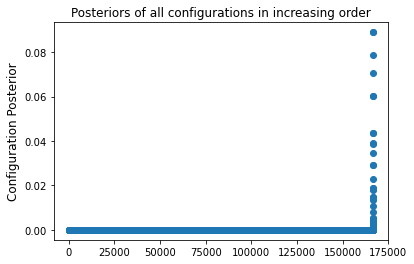

In [7]:
##Q3 plot

## plot Posteriors of all of the valid configurations in increasing order
posterior.sort()## sort by order
plt.scatter(range(len(posterior)), posterior)
plt.ylabel('Configuration Posterior', fontdict  = {'size': 12})
plt.title("Posteriors of all configurations in increasing order")
plt.show()

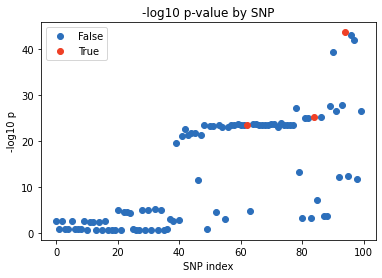

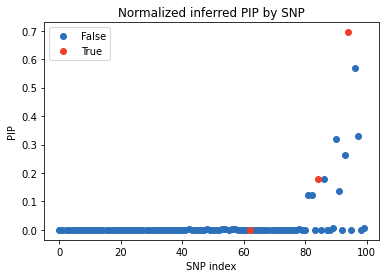

In [8]:
##Q4 plot

## plot -log10 P-values of the marginal z-scores of the 100 SNPs
groups = sum_df.groupby('causal')
colors = ['#2c6fbb', '#ef4026']
for oh, group in groups:
    plt.plot(group.index, group['-logp'], marker='o', linestyle='', label=bool(oh), color = colors[int(oh)])
plt.legend()
plt.xlabel('SNP index')
plt.ylabel('-log10 p')
plt.title("-log10 p-value by SNP")
plt.show()
## plot inferred posterior inclusion probabilities (PIP) of the 100 same SNPs
for oh, group in groups:
    plt.plot(group.index, group.inferred, marker='o', linestyle='', label=bool(oh), color = colors[int(oh)])
plt.legend()
plt.xlabel('SNP index')
plt.ylabel('PIP')
plt.title("Normalized inferred PIP by SNP")
plt.show()